In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import yaml
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import os
os.environ.pop("MPLDEBUG", None)

import torch
from torch.utils.data import DataLoader
from model import FlexControlTripleStreamsVAE
from data import get_flexcontrol_triplestream_dataset
from helpers.control_feature_utils import run_inference_and_extract_features_flex_model, run_inference_flex_model, extract_control_features_flex_model

Could not import fluidsynth. AUDIO rendering will not work.
Holoviews not installed. Please install holoviews to be able to generate heatmaps.


## Load Dataset

### Note: First run, it will take a while to load the dataset, but it will be cached for future runs.

In [3]:
config = yaml.safe_load(open('../helpers/configs/FlexControlTripleStreams_0.5.yaml', 'r'))
config['dataset_root_path'] = os.path.join("../", config['dataset_root_path'])
# todo - change to use the config from model
is_testing = True

dataset = get_flexcontrol_triplestream_dataset(
        config=config,
        subset_tag="validation",
        use_cached=True,
        downsampled_size=2000 if is_testing else None,
        print_logs=False                                #<---  Set to True to print dataset loading logs
    )

In [4]:

dataloader = DataLoader(
    dataset,
    batch_size=1024 ,
    shuffle=False,
    num_workers=0
)

## Load Model

In [ ]:
from model import load_model, FlexControlTripleStreamsVAE

model_path = 'models/step_444276.pth'
model = load_model(
    model_path=model_path,
    model_class=FlexControlTripleStreamsVAE,
    params_dict=config,
    is_evaluating=True
)

# model.config
#
# model.save('./resaved_model.pth')  # Save without JSON for testing
# model_new = load_model(
#     model_path="./resaved_model.pth",
#     model_class=FlexControlTripleStreamsVAE,
#     is_evaluating=True
# )
# FlexControlTripleStreamsVAE.load("./resaved_model.pth", is_evaluating=True)

In [6]:
# gt_data, pred_data, metadata = run_inference_and_extract_features(model, dataloader)
# gt_data.keys(), pred_data.keys()
inference_data = run_inference_flex_model(model, dataloader)
inference_data.keys()

100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


dict_keys(['input_grooves_gt', 'output_streams_gt', 'flat_outputs_gt', 'encoding_control1_tokens_gt', 'encoding_control2_tokens_gt', 'decoding_control1_tokens_gt', 'decoding_control2_tokens_gt', 'decoding_control3_tokens_gt', 'output_streams_pred', 'flat_outputs_pred', 'metadata'])

#### Get Token Distributions

In [7]:
# GT_Control Features
gt_controls = extract_control_features_flex_model(
    flat_input_hvo=inference_data['input_grooves_gt'],
    flat_output_hvo=inference_data['flat_outputs_gt'],
    output_streams_hvo=inference_data['output_streams_gt']
)

# Predicted Control Features
pred_controls = extract_control_features_flex_model(
    flat_input_hvo=inference_data['input_grooves_gt'],
    flat_output_hvo=inference_data['flat_outputs_pred'],
    output_streams_hvo=inference_data['output_streams_pred']
)

gt_controls.keys(), pred_controls.keys()

(dict_keys(['encoding_control1_tokens', 'decoding_control1_tokens', 'encoding_control2_tokens', 'decoding_control2_tokens', 'decoding_control3_tokens']),
 dict_keys(['encoding_control1_tokens', 'decoding_control1_tokens', 'encoding_control2_tokens', 'decoding_control2_tokens', 'decoding_control3_tokens']))

In [8]:
(gt_controls['encoding_control2_tokens'] - dataset.encoding_control_tokens[:, 1].numpy()).max()

4

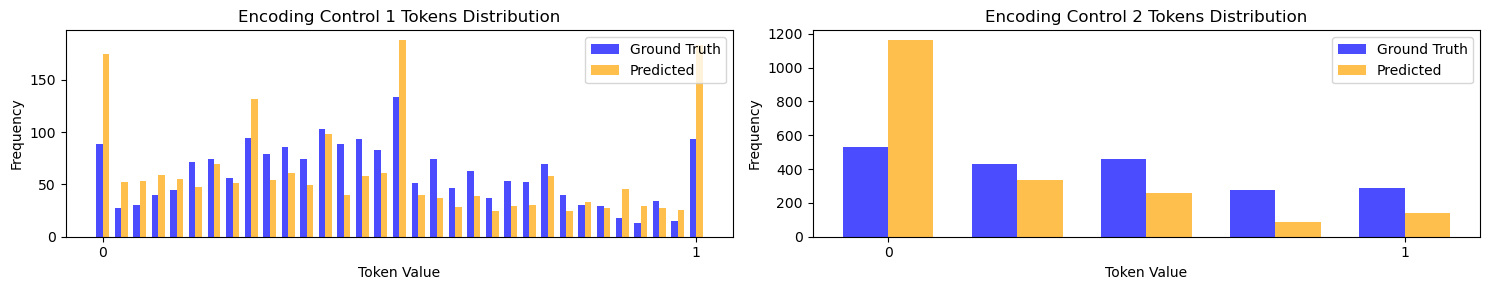

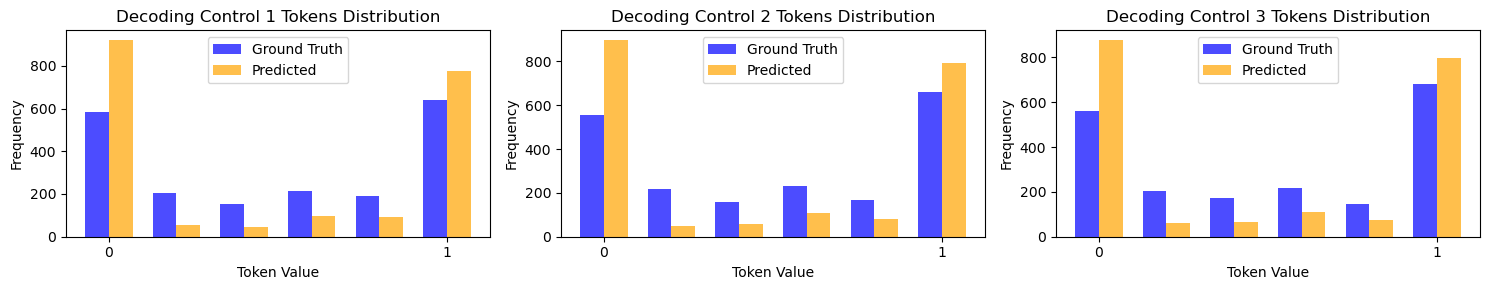

In [9]:
def plot_token_distributions(gt_tokens, pred_tokens, title, ax=None):
    # tokens are assumed to have 0 to N integer values
    n_bins = max(gt_tokens.max(), pred_tokens.max()) + 1
    bin_edges = np.arange(n_bins + 1) - 0.5  # Create bin edges centered on integers
    gt_hist, _ = np.histogram(gt_tokens, bins=bin_edges)
    pred_hist, _ = np.histogram(pred_tokens, bins=bin_edges)
    width = 0.35  # Width of the bars
    x = np.arange(n_bins)  # The label locations
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 2))
    ax.bar(x - width/2, gt_hist, width, label='Ground Truth', alpha=0.7, color='blue')
    ax.bar(x + width/2, pred_hist, width, label='Predicted', alpha=0.7, color='orange')
    ax.set_xlabel('Token Value')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.set_xticks([x[0], x[-1]])  # Show every second tick for clarity
    ax.set_xticklabels([0, 1])
    ax.legend()


# create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

# Plot Encoding Control 1 Tokens
plot_token_distributions(
    gt_tokens=gt_controls['encoding_control1_tokens'],
    pred_tokens=pred_controls['encoding_control1_tokens'],
    title='Encoding Control 1 Tokens Distribution',
    ax=axs[0]
)

# Plot Encoding Control 2 Tokens
plot_token_distributions(
    gt_tokens=gt_controls['encoding_control2_tokens'],
    pred_tokens=pred_controls['encoding_control2_tokens'],
    title='Encoding Control 2 Tokens Distribution',
    ax=axs[1]
)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
# Plot Decoding Control 1 Tokens
plot_token_distributions(
    gt_tokens=gt_controls['decoding_control1_tokens'],
    pred_tokens=pred_controls['decoding_control1_tokens'],
    title='Decoding Control 1 Tokens Distribution',
    ax=axs[0]
)

# Plot Decoding Control 2 Tokens
plot_token_distributions(
    gt_tokens=gt_controls['decoding_control2_tokens'],
    pred_tokens=pred_controls['decoding_control2_tokens'],
    title='Decoding Control 2 Tokens Distribution',
    ax=axs[1]
)

# Plot Decoding Control 3 Tokens
plot_token_distributions(
    gt_tokens=gt_controls['decoding_control3_tokens'],
    pred_tokens=pred_controls['decoding_control3_tokens'],
    title='Decoding Control 3 Tokens Distribution',
    ax=axs[2]
)
plt.tight_layout()
plt.show()